In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import frame as fr
import algo_result as alg_res
import os
from scipy.fft import fft, fftn, fftfreq, fftshift
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import graphviz

%run algo_process.ipynb


In [2]:
def peak_search_dopp(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_strength = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    doppler_details = {"peak_count":0,"total_harmonic_relative_strength":0,"peak_bin":[],"harmonic_relative_strength":[],"max_peak_strength":peak_strength}
    harmonic_strength = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc <= Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            harmonic_strength += pvc[0]
            counter += 1
            doppler_details["peak_bin"].append(fbc)
            doppler_details["harmonic_relative_strength"].append(pvc[0]/peak_strength)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    doppler_details["peak_count"] = counter
    doppler_details["total_harmonic_relative_strength"] = harmonic_strength/peak_strength
    return doppler_details

In [3]:
def doppler_details_extraction(spectrum,T_Lo_thr,T_Mi_thr,T_Hi_thr):
    doppler_details = peak_search_dopp(spectrum,0,np.Inf,0)
    Hi_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    Mi_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    Lo_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    for peak_idx in range(doppler_details["peak_count"]):
        if doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Lo_thr and doppler_details["harmonic_relative_strength"][peak_idx] <= 1/T_Mi_thr:
            Lo_details["peak_count"] += 1
            Lo_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Lo_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
        elif doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Mi_thr and doppler_details["harmonic_relative_strength"][peak_idx] <= 1/T_Hi_thr:
            Mi_details["peak_count"] += 1
            Mi_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Mi_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
        elif doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Hi_thr:
            Hi_details["peak_count"] += 1
            Hi_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Hi_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
    Lo_details["total_harmonic_relative_strength"] = sum(Lo_details["harmonic_relative_strength"])
    Mi_details["total_harmonic_relative_strength"] = sum(Mi_details["harmonic_relative_strength"])
    Hi_details["total_harmonic_relative_strength"] = sum(Hi_details["harmonic_relative_strength"])
    return Hi_details,Mi_details,Lo_details,doppler_details

In [4]:
SAMPLES_PER_CHIRP = 64
CHIRPS_PER_FRAME = 128
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 512
ANTENNA_SPACING = 6.22e-3

PEAK_THRESHOLD = 0.005 # normalized FFT absolute minimum strength 
PEAK_SLICE = 2 #meters around target
PEAK_WIDTH = 1 #integer
PEAK_RELEVANCE = 0 #minimum distance between pvl1,pvr1 and pvc
SEARCH_ZONE = 25 #split spectrum in slices of SEARCH_ZONE meters to find a single peak
MIN_DIST = 5 #minimum distance for detection

ANGLE_CALIBRATION = -150
ANGLE_PRECISION = 1

ANTENNA_NUMBER = 1

FRAME_REP_INTERVAL = 0.2

In [ ]:
classifier = xgb.XGBClassifier()
classifier.load_model('../statistics_data_processing/code/Trained_stuff/boresight_diagonal_azimuth_model.model')

asd = pd.read_csv("../statistics_data_processing/code/Trained_stuff/Boresight_Diagonal_azimuth.csv",delimiter='\t')
d = asd.to_dict("split")

###Get dictionary with performance for each number of feature
my_dictionary_list = []
for row_idx in range(len(d['data'])):
    for col_idx in range(len(d['columns'])):
        if d['columns'][col_idx] == 'support':
            split_bools = d['data'][row_idx][col_idx] = d['data'][row_idx][col_idx].replace("\n", "").replace("  "," ").replace("[","").replace("]","").split(" ")
            d['data'][row_idx][col_idx] = []
            for elem in split_bools:
                if elem == 'True':
                    d['data'][row_idx][col_idx].append(True)
                elif elem == 'False':
                    d['data'][row_idx][col_idx].append(False)
    best_params= dict(zip(d["columns"],d["data"][row_idx]))
    best_params[d['columns'][col_idx]] = d['data']
    my_dictionary_list.append(best_params)
###Get best performance    
max_score = 0
support = []
feature_names = []
for elem in my_dictionary_list:
    if elem['score'] > max_score:
        max_score = elem['score']
        support = elem['support']
        feature_names = elem['features'].replace("'","").replace('[','').replace(']','').replace('\n','').split(" ")

###Get feature importance
importance_type='weight'
fscores = classifier.get_booster().get_score(importance_type=importance_type)
feat_importances = []
for ft, score in fscores.items():
    feat_importances.append({'Feature': ft, 'Importance': score, 'Name': feature_names[int(ft[1:])]})
feat_importances = pd.DataFrame(feat_importances)
feat_importances = feat_importances.sort_values(
    by='Importance', ascending=False).reset_index(drop=True)
print(feat_importances)
###Sort labels with feature importance
feat_labels = []
for elem in feat_importances.values:
    feat_labels.append(elem[2])
feat_labels = np.flip(feat_labels)
fig,ax = plt.subplots(1,1,figsize=(10,10))

###Plot importance
importance_plot=plot_importance(classifier,ax=ax,importance_type=importance_type,show_values=False)
importance_plot.set_title(f"Feature importance (by {importance_type})")
importance_plot.set_yticklabels(feat_labels)
normalization_factors = pd.read_csv("../statistics_data_processing/code/Trained_stuff/boresight_diagonal_azimuth_norm_factors.csv",delimiter='\t').values
norm_mean = normalization_factors[0]
norm_scale = normalization_factors[1]

In [ ]:
#fig,ax = plt.subplots(1,1,figsize=(10,20))
#plot_tree(classifier,ax=ax)
#plt.savefig('Tree',format='png')

In [12]:
directory = '../../data/'

folders = []
folders.append('Dataset_2')
folders.append('Dataset_1')


for folder in folders:
    ###Calibration Data
    calibration_data = pd.read_csv(directory + folder+ '/environment_1.txt', sep='\t', header=None)
    calibration = calibration_data.select_dtypes(include = ['float']).values
    CALIBRATION_FRAME_NUMBER = len(calibration)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
    calibration_frames = []
    ###Create dataset
    for frame in range(CALIBRATION_FRAME_NUMBER):
        calibration_frames.append(fr.Frame(calibration[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                               SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T))

    average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
    for frame in range(1):
        for chirp in range(CHIRPS_PER_FRAME):
            average_calib_chirp += calibration_frames[frame].get_chirp(chirp)

    average_calib_chirp /= CHIRPS_PER_FRAME
    
    ###Target Data
    
    data_directory = os.fsencode(directory + folder + '/')

    for file in os.listdir(data_directory):
        filename = os.fsdecode(file)
        if filename.find('environment') == -1 and filename.endswith('.txt') and filename.find('azimuth') != -1:
            actual_filename = filename
            path = os.path.join(os.fsdecode(data_directory), filename)
            print(path)                    
            data = pd.read_csv(path, sep='\t', header=None)
            data.columns = ["idx","I_RX1","Q_RX1"]

            recording = data.select_dtypes(include = ['float']).values
            FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
            Hu_bi_frame = []
            ###Create dataset
            for frame in range(FRAME_NUMBER):
                Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                                       SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)) 
            ###Calibrate frames
            calibrate = True
            if calibrate:
                for frame in range(FRAME_NUMBER):
                    Hu_bi_frame[frame].calibrate(average_calib_chirp)

            xf = np.arange(0,RANGE_PAD)
            range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
            range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
            vel_bin = fftshift(fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL))*SPEED_OF_LIGHT/(2*START_FREQUENCY) 

            Target_observations = []
            Range_spectrum_history = []
            Unfiltered_spectrum_history = []
            Target_info_list = []
            Target_presence_list = []

            ###Process frames
            for frame in range(FRAME_NUMBER):
                data_out,target_info, MTI_out = algo_process(Hu_bi_frame[frame],RANGE_PAD,CHIRPS_PER_FRAME,DOPPLER_PAD,PEAK_THRESHOLD,PEAK_SLICE,PEAK_WIDTH,PEAK_RELEVANCE,SEARCH_ZONE,ANGLE_CALIBRATION,ANGLE_PRECISION,round(LAMBDA/ANTENNA_SPACING),range2bin)
                Range_spectrum_history.append(MTI_out)
                Unfiltered_spectrum_history.append(abs(data_out[:,0,0]))
                if(target_info.num_targets > 0 and target_info.location[0] < SEARCH_ZONE and target_info.location[0] > MIN_DIST):
                    Target_info_list.append(target_info)
                    Target_presence_list.append(1)
                    target_doppler_spec = target_info.doppler_spectrum[:,0]
                    Target_observations.append(np.append(np.roll(target_doppler_spec,DOPPLER_PAD//2-np.argmax(target_doppler_spec)), target_info.location[0]))
                else:
                    Target_presence_list.append(0)  

            df = pd.DataFrame(Target_observations).T
            output_path = "../statistics_data_processing/data_NN/"

            output_filename = actual_filename.split('.')[0]
            extension = '_statistics'
            df.T.to_csv(output_path+output_filename+'_'+folder+extension+'.txt', sep='\t',index=False, header=False)

../../data/Dataset_2/walking_azimuth_2.txt
../../data/Dataset_2/biking_azimuth_1.txt
../../data/Dataset_2/walking_azimuth_1.txt
../../data/Dataset_2/driving_azimuth_1.txt
../../data/Dataset_2/driving_azimuth_2.txt
../../data/Dataset_2/walking_azimuth_3.txt
../../data/Dataset_2/driving_azimuth_3.txt
../../data/Dataset_2/biking_azimuth_2.txt
../../data/Dataset_1/walking_azimuth_2.txt
../../data/Dataset_1/biking_azimuth_1.txt
../../data/Dataset_1/walking_azimuth_1.txt
../../data/Dataset_1/driving_azimuth_1.txt
../../data/Dataset_1/driving_azimuth_2.txt
../../data/Dataset_1/biking_azimuth_2.txt


In [ ]:
predictions_converted = []
for pred in predictions:
    if pred == 0 or pred == 3 or pred == 6:
        predictions_converted.append(0)
    elif pred == 1 or pred == 4 or pred == 7:
        predictions_converted.append(1)
    elif pred == 2 or pred == 5 or pred == 8:
        predictions_converted.append(2)
    elif pred == -1:
        predictions_converted.append(-1)
predictions = predictions_converted
print(predictions)

<ipython-input-172-b67f6f6f9c61>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


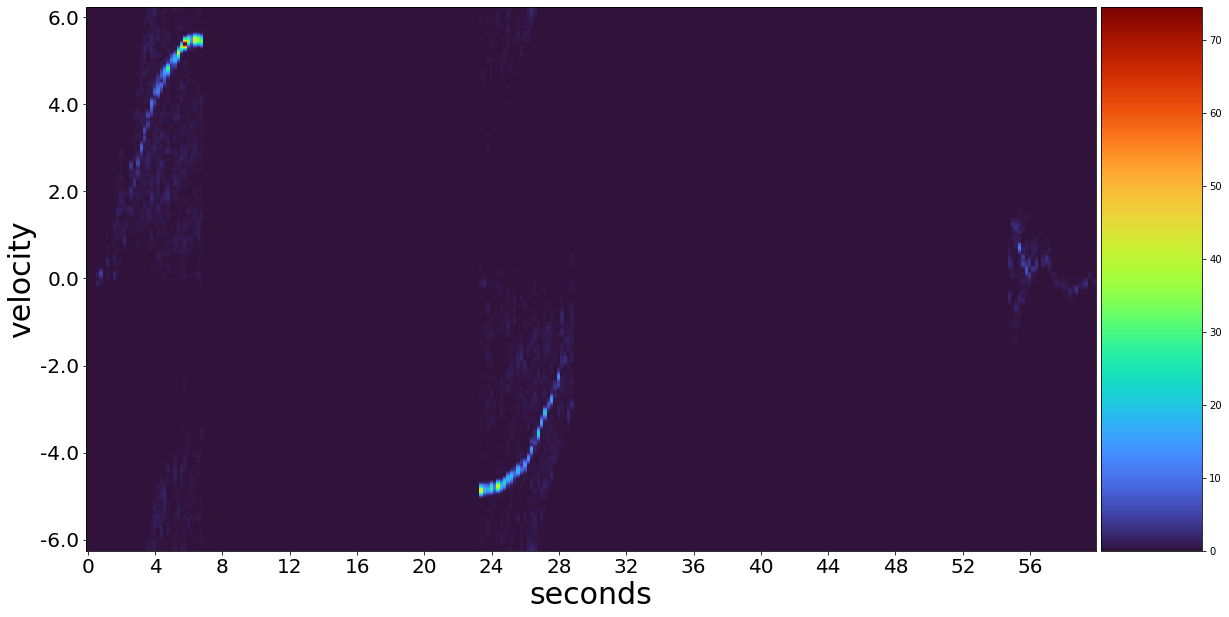

In [172]:
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
### PLOT DOPPLER VS TIME
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(target_doppler_spec))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(target_doppler_spec), 100)
ax.pcolormesh(np.arange(0,counter)*FRAME_REP_INTERVAL,vel_bin,target_doppler_spec, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('velocity', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
plt.savefig('Thesis_figures/'+'all_doppler_driving_diagonal_1.png')
            

<ipython-input-148-3a5077f1ffce>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


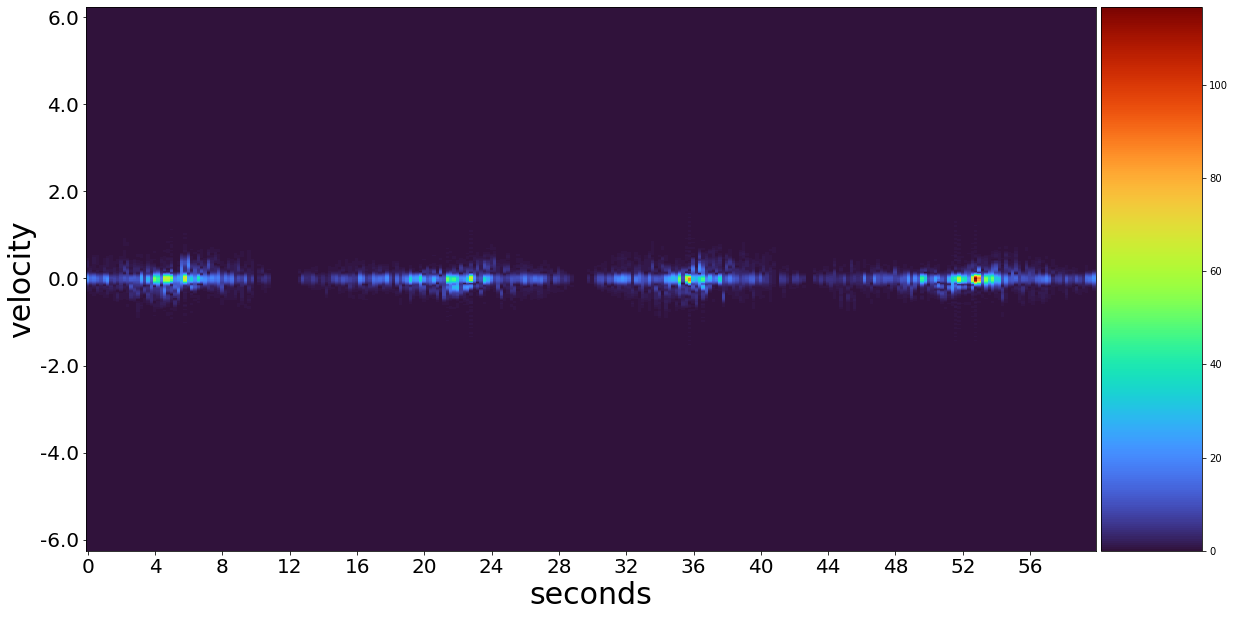

In [148]:
%matplotlib inline
rolled_doppler = np.zeros(target_doppler_spec.shape)

for frame in range(FRAME_NUMBER):
    if max(target_doppler_spec[:,frame]) > 0:
        max_idx = np.argmax(target_doppler_spec[:,frame])
        #round(sum([(i)*target_doppler_spec[i,frame] for i in range(DOPPLER_PAD)])/sum(target_doppler_spec[:,frame]))
        rolled_doppler[:,frame] = np.roll(target_doppler_spec[:,frame],(DOPPLER_PAD//2 - max_idx))

fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(rolled_doppler))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(rolled_doppler), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,vel_bin,rolled_doppler, cmap=cmap, norm=norm, shading='nearest')
#ax.contourf(np.arange(0,FRAME_NUMBER),vel_bin,rolled_doppler, levels, cmap=cmap, norm=norm)
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('velocity', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
#plt.savefig('Thesis_figures/'+'centered_all_doppler_biking_boresight_1.png')

In [ ]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[12,5])
from_second_number = 100#round(32/FRAME_REP_INTERVAL)
for col in range(column_plots):
    for row in range(row_plots):
        data = target_doppler_spec[:,row + row_plots*col + from_second_number].reshape((1,-1))[0,:]
        ax[row].plot(vel_bin,data)
plt.show()

In [ ]:
%matplotlib widget
fig,ax = plt.subplots(3,1, figsize=[12,5]) 
from_second_number = 105#round(32/FRAME_REP_INTERVAL)+5
#for frame in np.arange(from_second_number,from_second_number+1):
ax[0].plot(np.sum(target_doppler_spec[:,from_second_number:from_second_number+1],axis=1))
if(sum(target_doppler_spec[:,from_second_number:from_second_number+1][:] > 0)):
    actual_dopp = target_doppler_spec[:,from_second_number:from_second_number+1]
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[0].plot(weighted_avg_1,np.max(actual_dopp),'ro')
    low_tresh = np.max(actual_dopp)/T_Lo_thr*np.ones(length)
    mid_tresh = np.max(actual_dopp)/T_Mi_thr*np.ones(length)
    high_tresh = np.max(actual_dopp)/T_Hi_thr*np.ones(length)
    ax[0].plot(low_tresh)
    ax[0].plot(mid_tresh)
    ax[0].plot(high_tresh)
    ax[0].set_ylim((0,high_tresh[0]*11/10))


    actual_dopp = np.roll(actual_dopp,DOPPLER_PAD//2 - round(weighted_avg_1[0]))
    ax[1].plot(actual_dopp)
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[1].plot(DOPPLER_PAD//2,np.max(actual_dopp),'ro')
    ax[1].plot(low_tresh)
    ax[1].plot(mid_tresh)
    ax[1].plot(high_tresh)

    weighted_std_1 = ([(i-DOPPLER_PAD//2)**2*actual_dopp[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])/(DOPPLER_PAD//4)**2
    ax[2].plot(np.arange(0,len(weighted_std_1))+DOPPLER_PAD//4,weighted_std_1,'bo')
    print(np.sqrt(sum(weighted_std_1)))
    print(round(weighted_avg_1[0]))

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(np.sum(target_doppler_spec[:,from_second_number:from_second_number+1],axis=1))
if(sum(target_doppler_spec[:,from_second_number:from_second_number+1][:] > 0)):
    actual_dopp = target_doppler_spec[:,from_second_number:from_second_number+1]
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax.plot(weighted_avg_1,np.max(actual_dopp),'ro')
    low_tresh = np.max(actual_dopp)/T_Lo_thr*np.ones(length)
    mid_tresh = np.max(actual_dopp)/T_Mi_thr*np.ones(length)
    high_tresh = np.max(actual_dopp)/T_Hi_thr*np.ones(length)
    ax.plot(low_tresh)
    ax.plot(mid_tresh)
    ax.plot(high_tresh)
    #ax.set_ylim((0,high_tresh[0]*11/10))

In [ ]:
def peak_search_details(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_power = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    harmonic_power = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    peak_info = {"peak_bin":[],"peak_strength":[],"max_peak_strength":peak_power}
    
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc < Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            peak_info["peak_bin"].append(fbc)
            peak_info["peak_strength"].append(pvc/peak_power)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    return peak_info
    

In [ ]:
frame_doppler_peaks_dict = []
for target in Target_info_list:
    max_bin = np.argmax(target.doppler_spectrum[:,0])
    frame_doppler_peaks_dict.append(peak_search_details(np.roll(target.doppler_spectrum[:,0]*target.location[0]**2,DOPPLER_PAD//2 - max_bin),0,np.Inf,0))

In [ ]:
%matplotlib widget
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
all_doppler_peaks = np.array([])
for frame in frame_doppler_peaks_dict:
    all_doppler_peaks = np.append(all_doppler_peaks,np.array(frame["peak_strength"]))
n,bins=np.histogram(all_doppler_peaks,5000)
cumulative_n = [0]
for idx in range(len(n)):
    cumulative_n.append(n[idx] + cumulative_n[idx])
ax.plot(bins,cumulative_n/cumulative_n[-1])
ax.set_xlim((0,0.8))

In [ ]:
peak_presence_frequency = np.zeros(len(bins)-1)
for frame_peaks in frame_doppler_peaks_dict:
    for bin_idx in range(len(bins)-1):
        for peak in frame_peaks['peak_strength']:
            if bins[bin_idx] <= peak and bins[bin_idx+1] >= peak:
                peak_presence_frequency[bin_idx] += 1
                break               
    

fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list))
                

In [ ]:
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list)**2*n)
ax.set_xlim((0,0.04))

<ipython-input-134-74ce5ae734b0>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


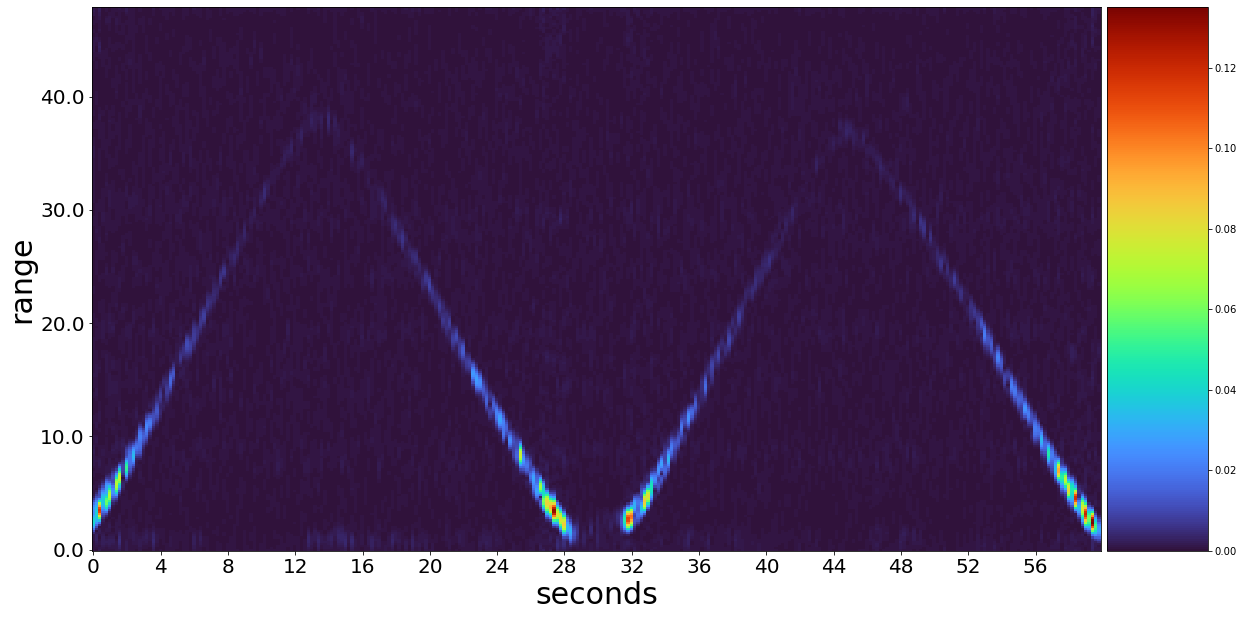

In [134]:
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Range_spectrum_history))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(Range_spectrum_history), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,range_bin,np.array(Range_spectrum_history).T, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('range', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
#plt.savefig('Thesis_figures/'+'MTI_range_biking_boresight_1.png')

<ipython-input-135-c0522d86ef50>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


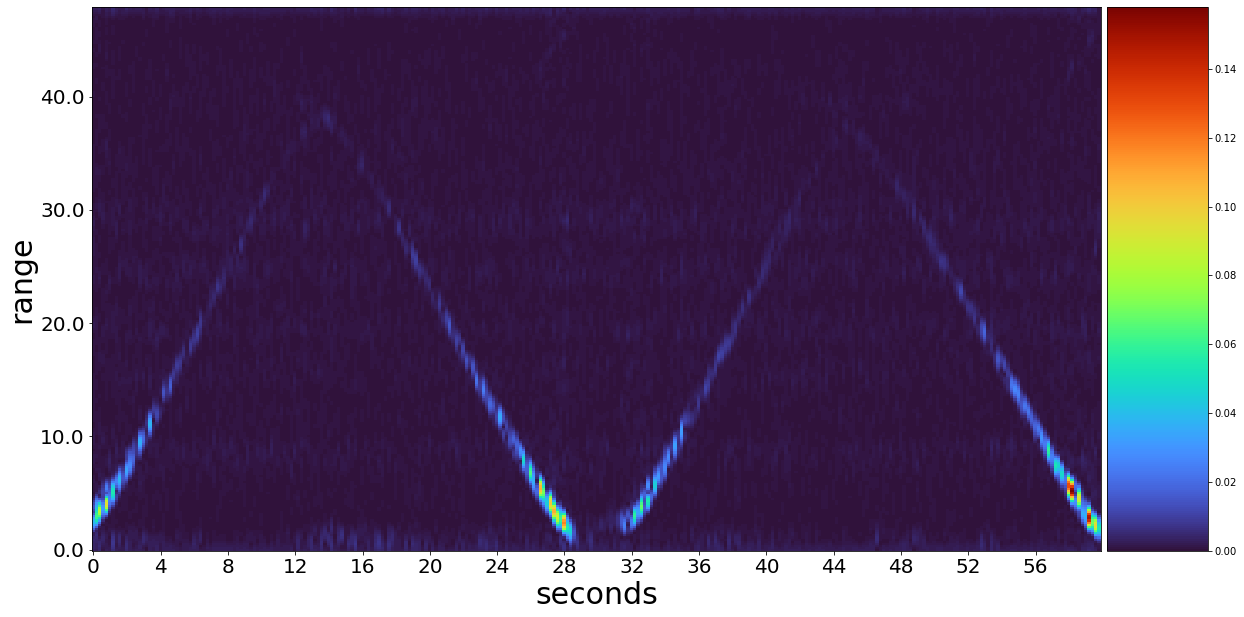

In [135]:
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Unfiltered_spectrum_history))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(Unfiltered_spectrum_history), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,range_bin,np.array(Unfiltered_spectrum_history).T, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('range', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
#plt.savefig('Thesis_figures/'+'Unfiltered_range_biking_boresight_1.png')

In [ ]:
%matplotlib widget
column_plots = 1
row_plots = 2
fig,ax = plt.subplots(row_plots,column_plots,figsize=[12,5])
from_second_number = 0
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = Target_info_list[row + row_plots*col + from_second_number].print[:,:,0].T.reshape((1,-1))[0,:]
        ax[row].set_ylim(0,0.2)
        ax[row].plot(data)
        ax[row].plot(separator_list[:],'ro',markersize=0.5)
plt.show()

peak_avg = sum(np.max(Target_info_list[from_second_number].print[:,:,0],axis=0))/CHIRPS_PER_FRAME

In [ ]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[20,10])
from_second_number = 9
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = np.max(Target_info_list[row + row_plots*col + from_second_number].print[:,:,0],axis=0).T.reshape((1,-1))[0,:]
        ax[row].hist(data,bins=100,range=(0,0.2),density=False)
plt.show()
print(Target_info_list[from_second_number].location[0])

In [ ]:
peak_collection = []
for target in Target_info_list:
    peak_strength = np.max(target.print[:,:,0],axis=0)*target.location[0]**2
    peak_strength_mean = np.sum(peak_strength)/CHIRPS_PER_FRAME
    peak_collection.append(peak_strength-peak_strength_mean)
peak_collection = np.array(peak_collection).reshape((1,-1))
_=plt.hist(peak_collection[0,:],bins=100)

In [ ]:

from matplotlib.animation import FuncAnimation, writers
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(25, 25))

classes = ['Pedestrian','Cyclist','Car']

ax1.title.set_text('Range')
ax1.title.set_fontsize(40)
ax2.title.set_fontsize(40)
ax2.title.set_text('Doppler')

ax1.set_xlim(range_bin[0], range_bin[-1])
ax1.set_ylim(0,np.max(Range_spectrum_history)*8/10)
ax2.set_xlim(vel_bin[0], vel_bin[-1])
ax1.tick_params(labelsize=30)
ax2.tick_params(labelsize=30)
#ax2.set_ylim(0,np.max(target_doppler_spec)*0.5)
ax1.axvline(MIN_DIST, lw=3, linestyle='--', color='black')
ax1.axvline(SEARCH_ZONE, lw=3, linestyle='--', color='black', label='Search Region')
ax1.plot(range_bin,np.ones(len(range_bin))*PEAK_THRESHOLD, lw=3, linestyle='dotted', color='gray', label='Detection Threshold')
# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=4, color='r', label='Filtered Range FFT Spectrum')
line2, = ax2.plot([], [], lw=4, color='r', label='Doppler FFT Spectrum')
line11, = ax1.plot([], [], 'D', color='black', markersize=15,label='Target location')
line21, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen', label='Feature Extractor')
line22, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen')
line23, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen')
line24, = ax2.plot([],[], lw=3, linestyle='dashdot',color='royalblue', label='Feature Extractor')
line25, = ax2.plot([],[], lw=3, linestyle='dashdot',color='royalblue')
line = [line1, line2, line21,line22,line23,line24,line25, line11]
ax1.legend(fontsize=20,loc=1)
ax2.legend(fontsize=20,loc=1)
#plt.xlabel(r'meters')
#plt.ylabel(r'fft magnitude')
text_axis = ax2.text(.2, -.2, 'Class:'+'No prediction available', style='italic',fontsize=60,
        bbox={'facecolor': 'bisque', 'alpha': 0.5, 'pad': 10},visible=True,transform=ax2.transAxes)
#
# animation function
def animate(i):
    line[0].set_data(range_bin, Range_spectrum_history[i])
    if predictions[i] == -1:
        text_axis.set_text('Class:'+'No prediction available')
    elif predictions[i] == 0:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    elif predictions[i] == 1:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    elif predictions[i] == 2:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    if(Target_presence_list[i]>0):
        #ax1.set_ylim(0,np.max(Range_spectrum_history[i]*11/10))
        ax2.set_ylim(0,np.max(target_doppler_spec[:,i])*11/10)
        line[1].set_data(vel_bin,target_doppler_spec[:,i])
        line[2].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Lo_thr)
        line[3].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Mi_thr)
        line[4].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Hi_thr)
        line[5].set_data(vel_bin,np.roll(np.array(bi_quadratic)*np.max(target_doppler_spec[:,i]),np.argmax(target_doppler_spec[:,i])-DOPPLER_PAD//2))
        line[6].set_data(vel_bin,np.roll(np.array(hor_quadratic)*np.max(target_doppler_spec[:,i]),np.argmax(target_doppler_spec[:,i])-DOPPLER_PAD//2))
        line[7].set_data(range_bin[np.argmax(Range_spectrum_history[i])],np.max(Range_spectrum_history[i]))
    else:
        for i in np.arange(1,8):
            line[i].set_data([],[])
    return line

anim = FuncAnimation(fig, animate, frames=FRAME_NUMBER)
Writer = writers['ffmpeg']
writer = Writer(fps=1/(FRAME_REP_INTERVAL), metadata={'artist':'Me'}, bitrate=3600)

anim.save('../../videos/'+folder+'_'+actual_filename + '_complete_model' +'.mp4',writer)

In [ ]:
print(len(Range_spectrum_history[0]))

In [ ]:
print(Target_presence_list)